In [4]:
import os 
import sys 
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

In [5]:
import matplotlib.pyplot as plt
from model_tuned_12082024 import DeconvolutionModel

In [6]:
def add_gaussian_noise(tensor, device, mean=0, stddev=0.1):
    noise=(torch.randn_like(tensor)*stddev+mean).to(device)
    noised_tensor=tensor+noise
    return noised_tensor

In [7]:
device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
print(f"Using {device} device")

n = 10000
known_freqs_file = f'known_freqs_{n}.npy'
snv_freqs_file = f'snv_freqs_{n}.npy'

Using mps device


In [8]:
known_freqs=np.load(known_freqs_file)
snv_freqs=np.load(snv_freqs_file)

In [9]:
known_freqs=torch.from_numpy(known_freqs).to(device)
snv_freqs=torch.from_numpy(snv_freqs).to(device)
snv_freqs=add_gaussian_noise(snv_freqs, device)

In [10]:
dataset = TensorDataset(snv_freqs, known_freqs)

total_size = len(dataset)
test_size = total_size // 10  # 10% for test
validation_size = total_size // 10  # 10% for validation
train_size = total_size - test_size - validation_size  # 80% train

# Split the dataset
train_dataset, validation_dataset, test_dataset = random_split(
        dataset, [train_size, validation_size, test_size]
    )

# verify sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(validation_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 8000
Validation set size: 1000
Test set size: 1000


In [15]:
batch_size = 1000  # Arbitrarily chosen
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
input_size = snv_freqs.shape[1]
output_size = known_freqs.shape[1]

In [18]:
num_hidden_layers=5
model = DeconvolutionModel(input_size, output_size, num_hidden_layers, device)

Using mps device


In [19]:
model.fit(train_loader, validation_loader, epochs=1000)

# Evaluate the model
model.evaluate(validation_loader)

# Predict using the model
predictions, actuals = model.predict(test_loader)

Epoch 1, Train loss: 0.006058, Validation loss: 0.006144
Epoch 2, Train loss: 0.006060, Validation loss: 0.006159
Epoch 3, Train loss: 0.006053, Validation loss: 0.006164
Epoch 4, Train loss: 0.006060, Validation loss: 0.006170
Epoch 5, Train loss: 0.006056, Validation loss: 0.006178
Epoch 6, Train loss: 0.006061, Validation loss: 0.006189
Epoch 7, Train loss: 0.006050, Validation loss: 0.006196
Epoch 8, Train loss: 0.006056, Validation loss: 0.006199
Epoch 9, Train loss: 0.006044, Validation loss: 0.006200
Epoch 10, Train loss: 0.006043, Validation loss: 0.006200
Epoch 11, Train loss: 0.006052, Validation loss: 0.006199
Epoch 12, Train loss: 0.006040, Validation loss: 0.006199
Epoch 13, Train loss: 0.006040, Validation loss: 0.006198
Epoch 14, Train loss: 0.006040, Validation loss: 0.006198
Epoch 15, Train loss: 0.006045, Validation loss: 0.006198
Epoch 16, Train loss: 0.006053, Validation loss: 0.006197
Epoch 17, Train loss: 0.006033, Validation loss: 0.006197
Epoch 18, Train loss: 0

In [20]:
print(predictions)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [21]:
sum(predictions[4])

0.999999962747097

In [ ]:
sum(actuals[1])

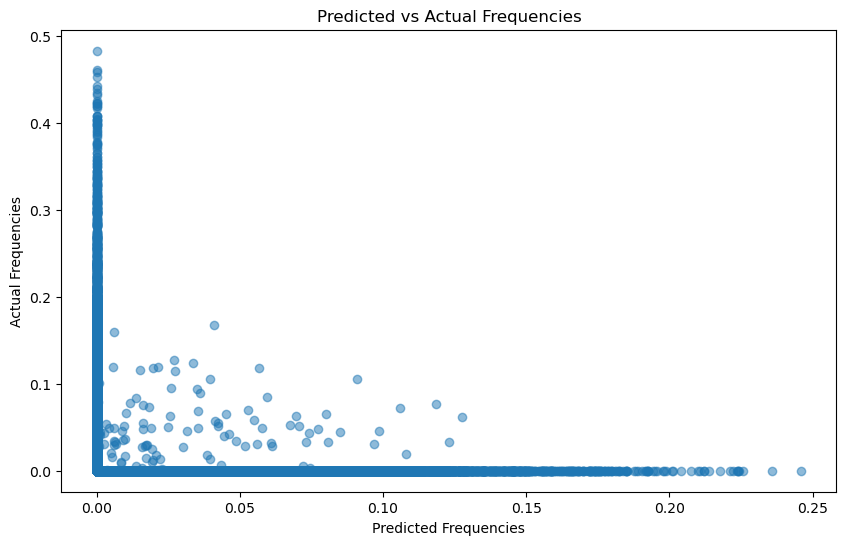

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(predictions.flatten(), actuals.flatten(), alpha=0.5)
plt.xlabel('Predicted Frequencies')
plt.ylabel('Actual Frequencies')
plt.title(f'Predicted vs Actual Frequencies')
plt.show()

In [ ]:
torch.save(model.model.state_dict(), 'diss')